In [1]:
import pandas as pd
import IPython.display as display
import numpy as np
import os,random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)

2.16.1


In [4]:
! git clone https://github.com/patrick013/Image-Classification-CNN-and-VGG.git Resources/Image-Classification-CNN-and-VGG

Cloning into 'Resources/Image-Classification-CNN-and-VGG'...
Updating files:   4% (2397/50016)
Updating files:   5% (2501/50016)
Updating files:   6% (3001/50016)
Updating files:   7% (3502/50016)
Updating files:   8% (4002/50016)
Updating files:   9% (4502/50016)
Updating files:   9% (4622/50016)
Updating files:  10% (5002/50016)
Updating files:  11% (5502/50016)
Updating files:  12% (6002/50016)
Updating files:  13% (6503/50016)
Updating files:  13% (6884/50016)
Updating files:  14% (7003/50016)
Updating files:  15% (7503/50016)
Updating files:  16% (8003/50016)
Updating files:  17% (8503/50016)
Updating files:  18% (9003/50016)
Updating files:  18% (9202/50016)
Updating files:  19% (9504/50016)
Updating files:  20% (10004/50016)
Updating files:  21% (10504/50016)
Updating files:  22% (11004/50016)
Updating files:  22% (11382/50016)
Updating files:  23% (11504/50016)
Updating files:  24% (12004/50016)
Updating files:  25% (12504/50016)
Updating files:  26% (13005/50016)
Updating file

## Prepare Data

In [3]:
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
BATCH_SIZE=64

# Create data frame of image details
def get_pathframe(path):
  filenames = os.listdir(path)
  categories = []
  paths=[]
  for filename in filenames:
    paths.append(path+filename)
    category = filename.split('.')[0]
    if category == 'dog':
      categories.append(1)
    else:
      categories.append(0)

  df= pd.DataFrame({
      'filename': filenames,
      'category': categories,
      'paths':paths
  })
  return df

df=get_pathframe("Resource/Image-Classification-CNN-and-VGG/dataset/dataset/")
df.tail(5)

,filename,category,paths
24995,dog.9995.jpg,1,Image-Classification-CNN-and-VGG/dataset/datas...
24996,dog.9996.jpg,1,Image-Classification-CNN-and-VGG/dataset/datas...
24997,dog.9997.jpg,1,Image-Classification-CNN-and-VGG/dataset/datas...
24998,dog.9998.jpg,1,Image-Classification-CNN-and-VGG/dataset/datas...
24999,dog.9999.jpg,1,Image-Classification-CNN-and-VGG/dataset/datas...


In [4]:
# Load, Resize, and Normalize images
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
  image /= 255.0
  return image

def convert_to_tensor(df):
  path_ds = tf.data.Dataset.from_tensor_slices(df['paths'])
  image_ds = path_ds.map(load_and_preprocess_image)
  onehot_label=tf.cast(df['category'], tf.int64)
  label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)
  return image_ds,label_ds

X,Y=convert_to_tensor(df)
print("Shape of X in data:", X)
print("Shape of Y in data:", Y)

Shape of X in data: <_MapDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>
Shape of Y in data: <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [23]:
dataset = tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=25000, seed=42)
dataset_train = dataset.take(22500)
dataset_test = dataset.skip(22500)

dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=True)
dataset_train


<_BatchDataset element_spec=(TensorSpec(shape=(64, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int64, name=None))>

## Check Images

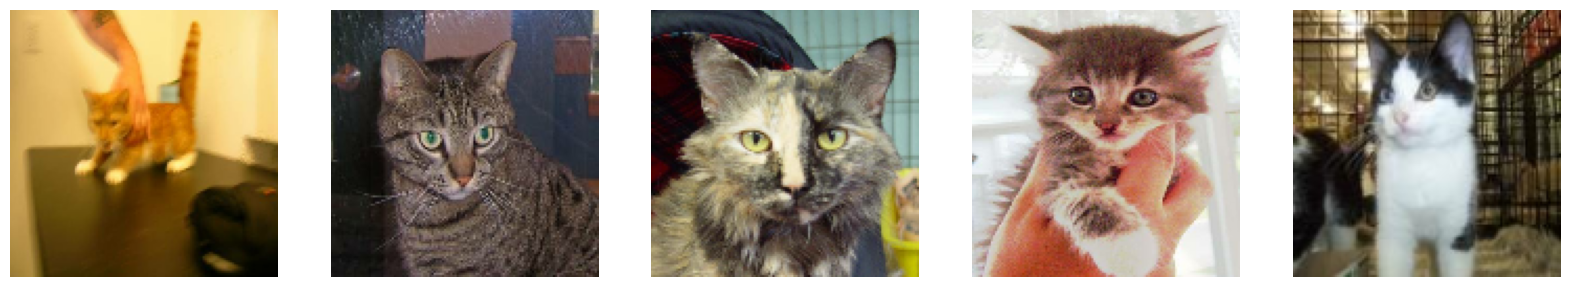

In [6]:
def plotimages(imagesls):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for image,ax in zip(imagesls, axes):
    ax.imshow(image)
    ax.axis('off')

imagesls=[]
for n, image in enumerate(X.take(5)):
  imagesls.append(image)

plotimages(imagesls)

## Build the Network

In [18]:
def My_CNNmodel(IMAGE_WIDTH, IMAGE_HEIGHT):

  model = tf.keras.models.Sequential()
  model.add(layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  opt=tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

  return model

In [19]:
model=My_CNNmodel(IMAGE_WIDTH, IMAGE_HEIGHT)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,705 (8.10 MB)

 Trainable params: 2,122,705 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

## Training Loop

In [20]:
hist=model.fit(dataset_train,epochs=20,validation_data=dataset_test)
model.save("C:/Users/caleb/OneDrive/Documents/Coding Projects/Deep_Learning/Resources/Image-Classification-CNN-and-VGG/models/My_CNNmodel.keras")

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 136s 318ms/step - accuracy: 0.6023 - loss: 0.6591 - val_accuracy: 0.7480 - val_loss: 0.5057
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 137s 314ms/step - accuracy: 0.7541 - loss: 0.5025 - val_accuracy: 0.8065 - val_loss: 0.4221
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 138s 314ms/step - accuracy: 0.8046 - loss: 0.4225 - val_accuracy: 0.8041 - val_loss: 0.4094
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 138s 316ms/step - accuracy: 0.8269 - loss: 0.3816 - val_accuracy: 0.8606 - val_loss: 0.3250
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 139s 317ms/step - accuracy: 0.8499 - loss: 0.3388 - val_accuracy: 0.8810 - val_loss: 0.2844
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 138s 314ms/step - accuracy: 0.8773 - loss: 0.2916 - val_accuracy: 0.9014 - val_loss: 0.2512
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 129s 287ms/step - accuracy: 0.8977 - loss: 0.2452 - val_accuracy: 0.9283 - val_loss: 0.1858
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 128s 286ms/step - accuracy: 0.9219 -

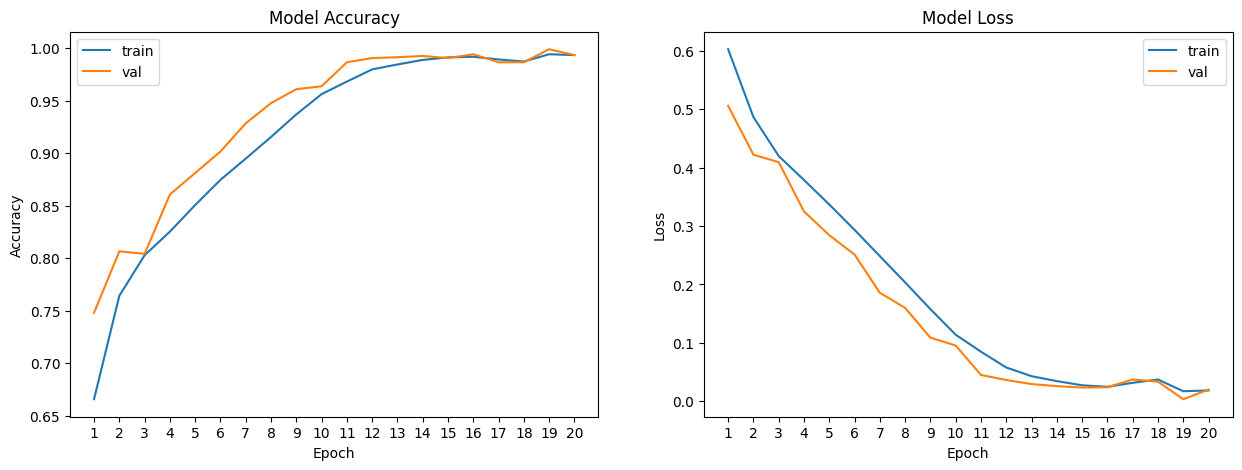

In [21]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1), labels=range(1, len(model_history.history[acc])+1))
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1), labels=range(1, len(model_history.history[acc])+1))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(hist)

## Evaluation (Initial Model)

39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 59ms/step - accuracy: 0.9940 - loss: 0.0194
Test: accuracy = 0.993189  ;  loss = 0.019503 


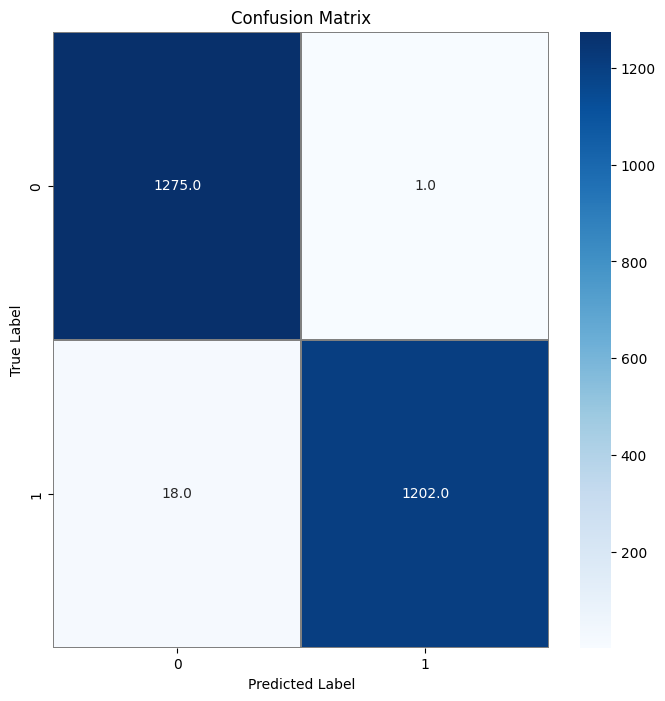

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Evaluate performance on validation set
loss, accuracy = model.evaluate(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

y_preds = []
y_labels = []

# Loop through dataset_test to make predictions and store labels for comparison
for features, labels in dataset_test:
    predictions = model.predict(features, verbose=0)
    y_preds.extend([1 if pred > 0.5 else 0 for pred in predictions.flatten()])
    y_labels.extend(labels.numpy().flatten())

# Create confusion matrix
confusion_mtx = confusion_matrix(y_labels, y_preds)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report = classification_report(y_labels, y_preds, target_names=['0','1'])
print(report)


##### I was able to achieve big improvements over the original model from the provided notebook by changing the way that the .shuffle() method was being applied to the dataset. The original buffer parameter of the shuffle method was set to 2000, which resulted in a fairly uneven mixture labels between the training set and the validation set. Fixing this issue by widening the buffer to allow more complete randomization across the whole dataset closed the gap in performance that was seen in the plots of the original notebook's model.

##### Additionally, the classification report and confusion matrix were not showing correctly, because the .shuffle() method actually changes the dataset to a "shuffle dataset" that re-shuffles each time it is accessed and that behavior apparently also extends to the subsets that were created when seperating the training and validation data. (It took hours of debugging and reading the tensorflow docs to trace the issue back to that, but you can tell that the data was being randomized when accessing to compare the predictions to the labels because the confusion matrix and classification report were both reading an accuracy of roughly 50% in the original notebook.)



## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Horizontal Flip
image_gen_flip = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen_flip.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory="Resources/Image-Classification-CNN-and-VGG/dataset/dataset_seperated/train",
                                                    shuffle=True,
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

In [ ]:
## Rotation
image_gen_rotate = ImageDataGenerator(rescale=1./255, rotation_range=45)
train_data_gen = image_gen_rotate.flow_from_directory(batch_size=BATCH_SIZE,
                                                       directory="Resources/Image-Classification-CNN-and-VGG/dataset/dataset_seperated/train",
                                                       shuffle=True,
                                                       target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

In [ ]:
## Zoom
image_gen_zoom = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
train_data_gen = image_gen_zoom.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory="Resources/Image-Classification-CNN-and-VGG/dataset/dataset_seperated/train",
                                                    shuffle=True,
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

In [ ]:
## Pull Together
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory="Resources/Image-Classification-CNN-and-VGG/dataset/dataset_seperated/train",
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')
validation_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory="Resources/Image-Classification-CNN-and-VGG/dataset/dataset_seperated/validation",
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')

plotimages([train_data_gen[0][0][0] for i in range(5)])

## Retrain the Model

In [ ]:
def Mynew_CNNmodel(IMAGE_WIDTH, IMAGE_HEIGHT):

  model = tf.keras.models.Sequential()
  model.add(layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  opt=tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

  return model

In [ ]:
new_model=Mynew_CNNmodel(IMAGE_WIDTH, IMAGE_HEIGHT)
new_model.summary()
new_hist=new_model.fit(train_data_gen,epochs=20,validation_data=validation_data_gen)
plot_model_history(new_hist)


##### This model is performing roughly the same as it did in the original notebook. Since it is using pre-seperated input data instead of the datasets prepared for the first model, its hard to know if that data also has issues with data distribution.



## Transfer Learning - VGG16

In [7]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

vggmodel = tf.keras.models.Model(pre_trained_model.input, x)

vggmodel.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

vggmodel.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,910,017 (72.14 MB)

 Trainable params: 11,274,753 (43.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [8]:
vgghist = vggmodel.fit(dataset_train, epochs=40, validation_data=dataset_test)

Epoch 1/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 701s 2s/step - accuracy: 0.6870 - loss: 0.5694 - val_accuracy: 0.8810 - val_loss: 0.2813
Epoch 2/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 729s 2s/step - accuracy: 0.8713 - loss: 0.2901 - val_accuracy: 0.8918 - val_loss: 0.2360
Epoch 3/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 730s 2s/step - accuracy: 0.8996 - loss: 0.2375 - val_accuracy: 0.9067 - val_loss: 0.2139
Epoch 4/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 879s 2s/step - accuracy: 0.9072 - loss: 0.2163 - val_accuracy: 0.9187 - val_loss: 0.1927
Epoch 5/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 895s 3s/step - accuracy: 0.9177 - loss: 0.2017 - val_accuracy: 0.9315 - val_loss: 0.1764
Epoch 6/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 803s 2s/step - accuracy: 0.9259 - loss: 0.1784 - val_accuracy: 0.9347 - val_loss: 0.1622
Epoch 7/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 827s 2s/step - accuracy: 0.9302 - loss: 0.1713 - val_accuracy: 0.9419 - val_loss: 0.1475
Epoch 8/40
351/351 ━━━━━━━━━━━━━━━━━━━━ 848s 2s/step - accuracy: 0.9360 - loss: 0.1590 - val_accu

In [9]:
vggmodel.save("C:/Users/caleb/OneDrive/Documents/Coding Projects/Deep_Learning/Resources/Image-Classification-CNN-and-VGG/models/vggmodel.keras")

## Evaluation

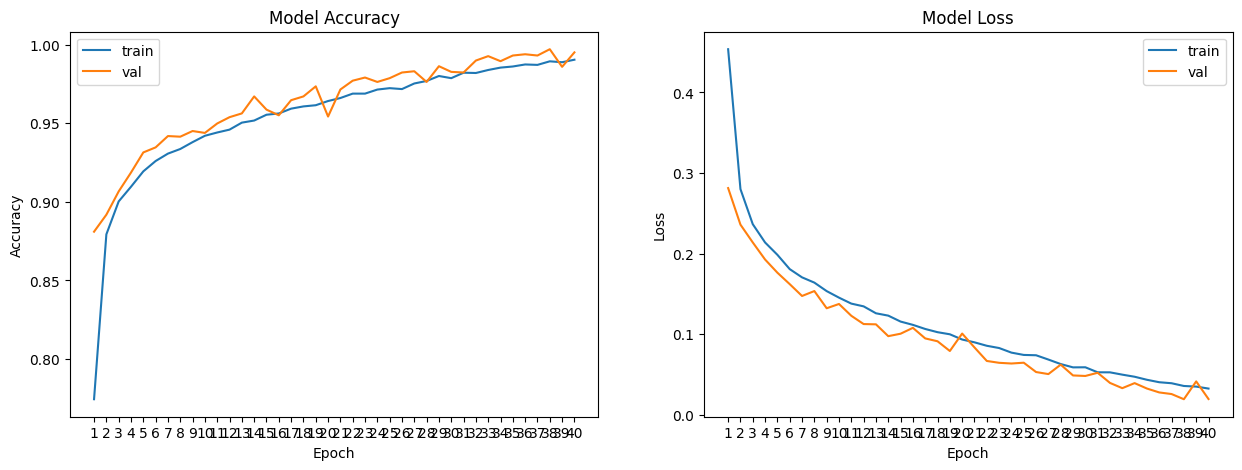

39/39 ━━━━━━━━━━━━━━━━━━━━ 62s 871ms/step - accuracy: 0.9986 - loss: 0.0156
Test: accuracy = 0.998798  ;  loss = 0.017721 


In [13]:
plot_model_history(vgghist)
loss, accuracy = vggmodel.evaluate(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

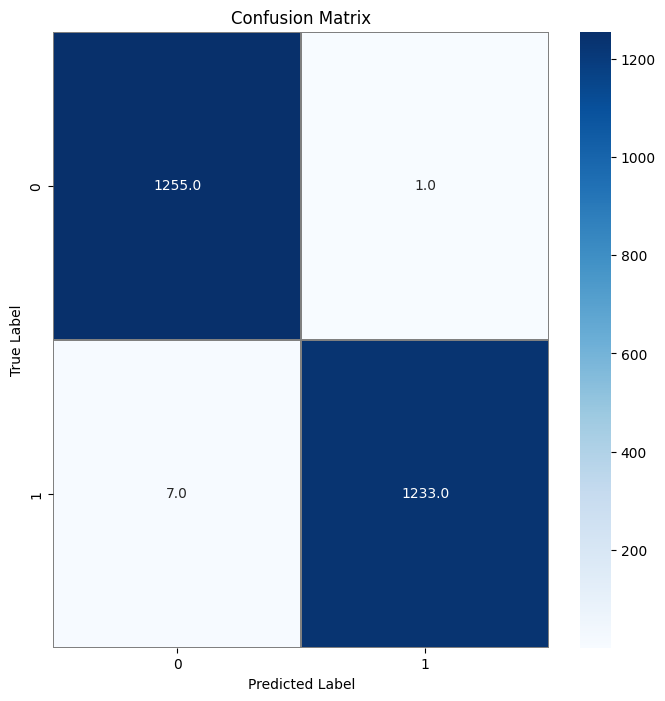

In [16]:
vgg_preds = []
vgg_labels = []

# Loop through dataset_test to make predictions and store labels for comparison
for features, labels in dataset_test:
    predictions = vggmodel.predict(features, verbose=0)
    vgg_preds.extend([1 if pred > 0.5 else 0 for pred in predictions.flatten()])
    vgg_labels.extend(labels.numpy().flatten())  # Assuming labels is a tensor

# Create Confusion Matrix
confusion_mtx = confusion_matrix(vgg_labels, vgg_preds)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [17]:
report = classification_report(vgg_labels, vgg_preds, target_names=['0','1'])
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1256
           1       1.00      0.99      1.00      1240

    accuracy                           1.00      2496
   macro avg       1.00      1.00      1.00      2496
weighted avg       1.00      1.00      1.00      2496



##### With improvements to the first model, it now slightly outperforms the VGG16 model above. This model might be underperforming due to the smaller learning rate that is being used or it may just need to be trained for more epochs since it's a much larger model, but the extensive training time makes it difficult to test other variations.